In [3]:
import numpy as np
import scipy as sp
import pylab as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout,BatchNormalization
from keras import optimizers
from tensorflow.keras.optimizers import Adam

### Data Loading

In [116]:
pima_data = np.load("pima.npz")

pima_data.files

['xall', 'yall', 'varnames']

In [117]:
data = np.concatenate((pima_data['xall'], pima_data['yall'].reshape((709,1))), axis=1)
columns = [var for var in pima_data['varnames']]
columns.append("Y")
df = pd.DataFrame(data, columns = columns)

In [118]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Y
0,7.0,159.0,64.0,0.0,0.0,27.4,0.294,40.0,-1.0
1,0.0,180.0,66.0,39.0,0.0,42.0,1.893,25.0,1.0
2,1.0,146.0,56.0,0.0,0.0,29.7,0.564,29.0,-1.0
3,2.0,71.0,70.0,27.0,0.0,28.0,0.586,22.0,-1.0
4,7.0,103.0,66.0,32.0,0.0,39.1,0.344,31.0,1.0
...,...,...,...,...,...,...,...,...,...
704,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,-1.0
705,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0,-1.0
706,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,-1.0
707,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0,1.0


The dataset consists of several medical predictor variables and one target variable for 709 female patients.

The target variable or outcome tells whether the person is actually diabetic : -1 if not diabetic and 1 if diabetic. 

Predictor variables included are:
* Pregnancies Number of times pregnant
* Glucose Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure Diastolic blood pressure (mm Hg)
* SkinThickness Triceps skin fold thickness (mm)
* Insulin 2-Hour serum insulin (mu U/ml)
* BMI Body mass index (weight in kg/(height in m²))
* DiabetesPedigreeFunction Diabetes pedigree function
* Age Age (years)


### Know the data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               709 non-null    float64
 1   Glucose                   709 non-null    float64
 2   BloodPressure             709 non-null    float64
 3   SkinThickness             709 non-null    float64
 4   Insulin                   709 non-null    float64
 5   BMI                       709 non-null    float64
 6   DiabetesPedigreeFunction  709 non-null    float64
 7   Age                       709 non-null    float64
 8   Y                         709 non-null    float64
dtypes: float64(9)
memory usage: 50.0 KB


In [8]:
df[pima_data['varnames']].mean()

Pregnancies                   3.747532
Glucose                     121.607898
BloodPressure                69.643159
SkinThickness                20.765867
Insulin                      80.531735
BMI                          32.453032
DiabetesPedigreeFunction      0.470961
Age                          33.021157
dtype: float64

Most other means have "normal" values ie values of normal people (without diabete). For example, the Glucose mean is 121 mg/dl while the glucose of normal people 2 hours after taking the test is below 140 mg/dl. Another example is the blood pressure. Here the blood pressure mean is 69 mm Hg while the blood pressure of normal people is below 80 mm Hg. It seems that ou dataset contains more healthy people than sick people.

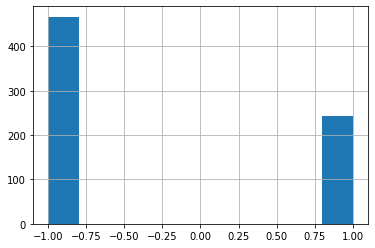

In [9]:
df['Y'].hist()

We were right to be worry, our dataset is unbalanced. The problem with the imbalanced dataset is that the model can favor the class with more records. We will have to take this into account when we will get our final mode

In [10]:
df[pima_data['varnames']].describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000,709.000000
mean,3.747532,121.607898,69.643159,20.765867,80.531735,32.453032,0.470961,33.021157
std,3.339502,30.490598,18.135582,15.899540,112.678399,6.950733,0.325256,11.669089
min,0.000000,44.000000,0.000000,0.000000,0.000000,18.200000,0.078000,21.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.500000,0.243000,24.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.374000,29.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.600000,0.629000,40.000000
max,17.000000,199.000000,122.000000,99.000000,744.000000,67.100000,2.420000,81.000000


If we look at the means of variables we can notice that variables do not have the same scale. Then when we look at tha standard deviation we also notice that variables dot not have similar standard deviation either.

This is a problem because if the features do not have similar scaling/variances it will lead to the domination of specific features. Our model would not completely reflect reality.

Therefore, we need to standardize our data. We will do it later.

#### Visualization of the data as scatterplots between pairs of variables (where the color is the class)

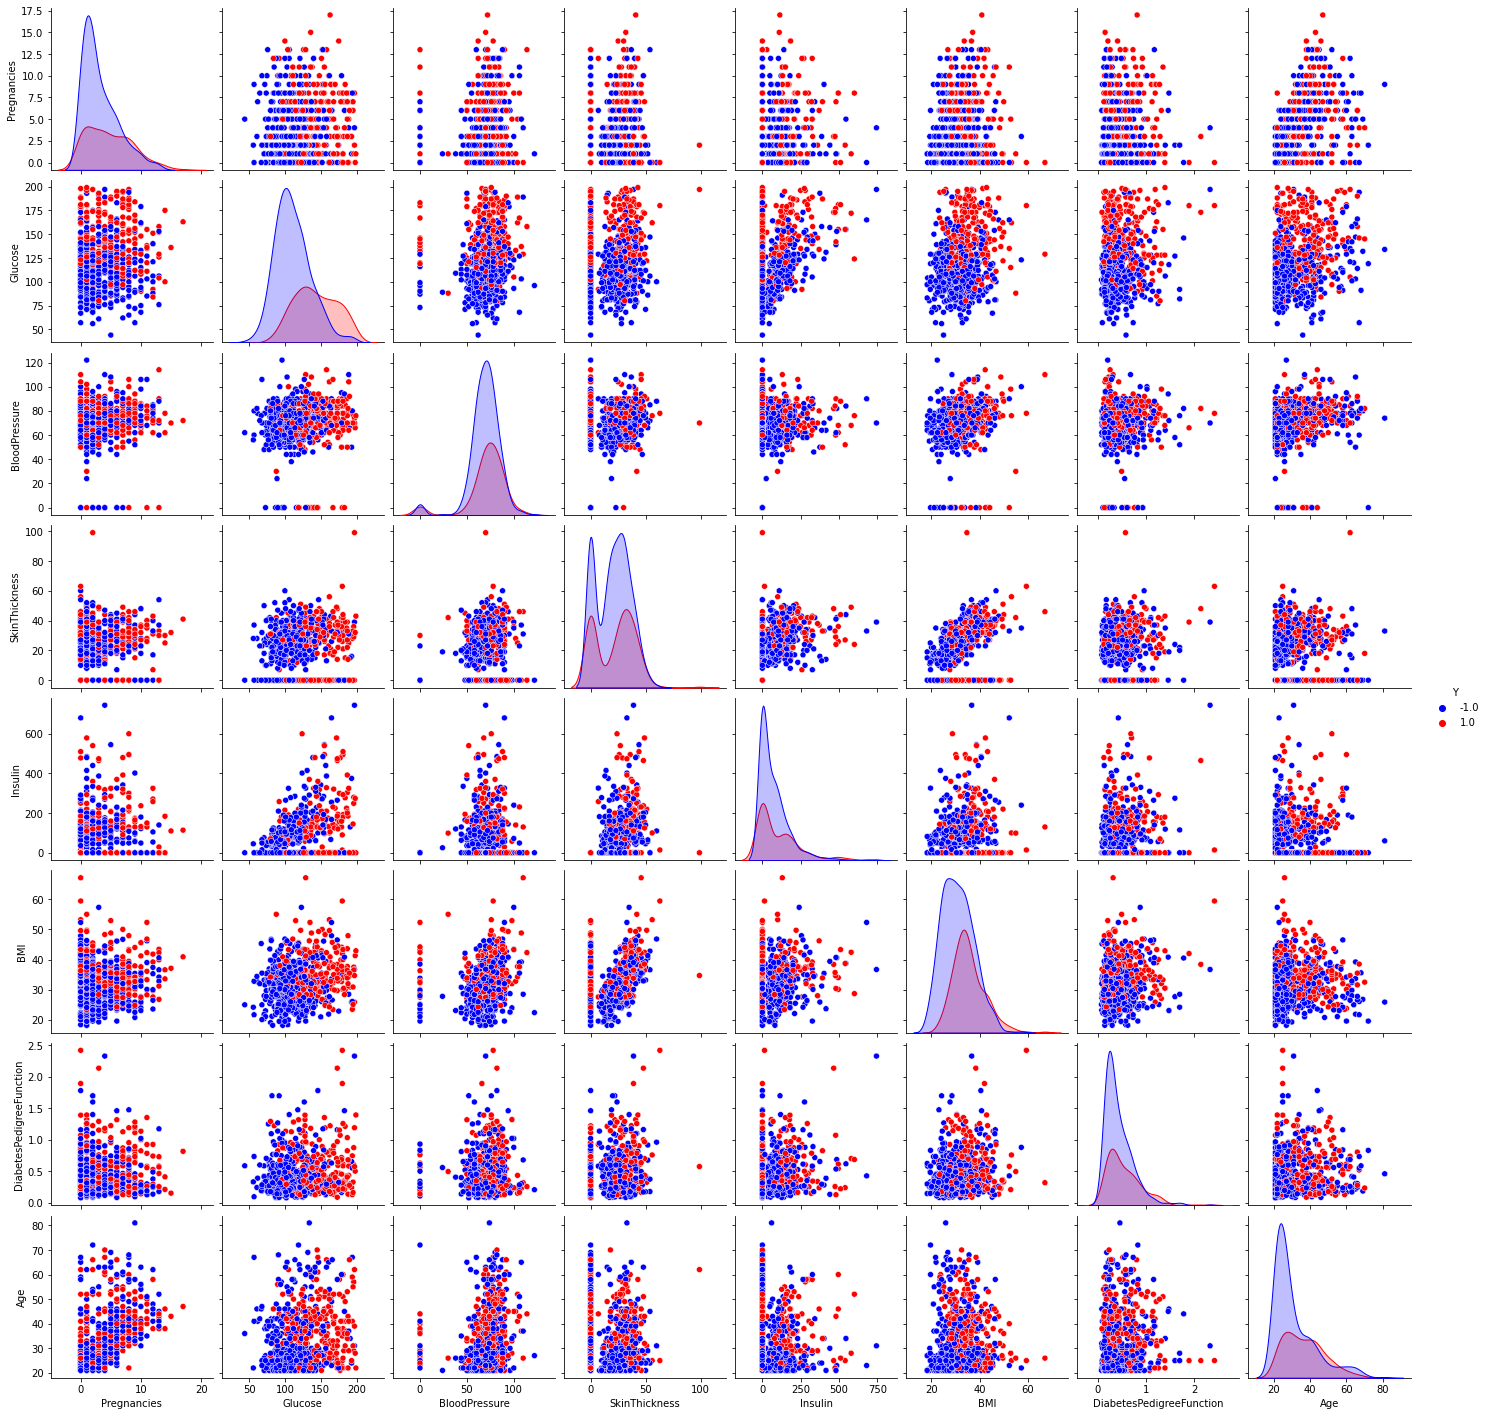

In [11]:
sns.pairplot(df, hue = 'Y' , palette = ["blue",'red'])

When we pair Glucose, BMI and DiabetesPedigreefunction with other variables we notice on the corresponding scatter plot that two clusters appear : this a separation between healthy people and sick people. Therefore these 3 variables seem to help predict the class.

Let's analyse this result from a medical perspective :

* The glucose tolerance test is often used to diagnose diabetes. Most of the time, a high blood glucose level may indicates diabetes. It is very unlikely to find another cause to a high blood glucose level.

* DiabetesPedigreefunction is also important when diagnosing diabetes. When a someone of your family already had diabete complications you are more likely to get diabete complications too.

* Multiple studies showed that having an elevated BMI is associated with increased risk of developing diabetes complications. While people having a normal BMI are considered as healthy and have much less risk of developing diabetes complications.

Therefore our result makes sens from a medical perspective.


### Preprocessing

Now, we will split our dataset in a train and test set.

In [126]:
train_size = 300

Xtrain, Xtest, Ytrain, Ytest = train_test_split(df[pima_data['varnames']], df['Y'], train_size=train_size, random_state=42)

In [13]:
Xtrain.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
37,2.0,110.0,74.0,29.0,125.0,32.4,0.698,27.0
157,5.0,162.0,104.0,0.0,0.0,37.7,0.151,52.0
237,1.0,119.0,86.0,39.0,220.0,45.6,0.808,29.0
679,2.0,99.0,60.0,17.0,160.0,36.6,0.453,21.0
374,0.0,135.0,94.0,46.0,145.0,40.6,0.284,26.0


In [14]:
Ytrain.head()

37    -1.0
157    1.0
237    1.0
679   -1.0
374   -1.0
Name: Y, dtype: float64

In [15]:
print("Number of elements in class 1: " + str(np.sum(Ytrain[Ytrain == 1])))
print("Number of elements in class -1 : " +str(np.abs(np.sum(Ytrain[Ytrain == -1]))))

Number of elements in class 1: 112.0
Number of elements in class -1 : 188.0


In the training set, there are a bit more of examples for the class -1 but there is not a class that is predominant. So, the model can really train effectively and its capacity to generalize could be good. Therefore, we will not use sophisticated method such as under-sampling or over-sampling here.

Now we need to standardize the training and test data

In [16]:
scaler = StandardScaler()

Xtrain_norm = scaler.fit_transform(np.array(Xtrain))

In [17]:
scaler = StandardScaler()

Xtest_norm = scaler.fit_transform(np.array(Xtest))

In the next part of the code, we will evaluate the performance of several models to determine if a patient given the features, is diabetic or not. 

## First let's use some linear models and Bayesian decision models

### LDA (Linear Discriminant Analysis)

In [18]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(Xtrain_norm, Ytrain)

LDA_accuracy = LDA.score(Xtest_norm, Ytest)
LDA_auc = roc_auc_score(Ytest, LDA.predict_proba(Xtest_norm)[:, 1])

print("LDA Accuracy = "+str(LDA_accuracy))
print("LDA AUC = "+str(LDA_auc))

LDA Accuracy = 0.7701711491442543
LDA AUC = 0.8323132065067549


Let's try a GridSearchCV to improve performances

In [19]:
LDA = LinearDiscriminantAnalysis()
shrinkage_params = np.linspace(0,1,100).tolist()
shrinkage_params.append('auto')

params={'shrinkage': shrinkage_params, 'solver': ['lsqr', 'eigen']}
cv = KFold(n_splits=10)

gridsLDA=GridSearchCV(LDA, params, cv=cv)
gridsLDA.fit(Xtrain_norm, Ytrain)

gridsLDA.best_params_

{'shrinkage': 0.4141414141414142, 'solver': 'lsqr'}

In [20]:
gridsLDA_accuracy = gridsLDA.score(Xtest_norm, Ytest)
gridsLDA_auc = roc_auc_score(Ytest, gridsLDA.predict_proba(Xtest_norm)[:, 1])

print("Best LDA Accuracy = "+str(gridsLDA_accuracy))
print("Best LDA AUC = "+str(gridsLDA_auc))

Best LDA Accuracy = 0.7995110024449877
Best LDA AUC = 0.8544802867383513


### QDA (Quadratic Discriminant Analysis)

In [21]:
QDA = QuadraticDiscriminantAnalysis()
QDA.fit(Xtrain_norm, Ytrain)

QDA_accuracy = QDA.score(Xtest_norm, Ytest)
QDA_auc = roc_auc_score(Ytest, QDA.predict_proba(Xtest_norm)[:, 1])

print("QDA Accuracy = "+str(QDA_accuracy))
print("QDA AUC = "+str(QDA_auc))

QDA Accuracy = 0.7603911980440098
QDA AUC = 0.815936035290874


Let's try to get better performances with GridSearchCV

In [22]:
QDA = QuadraticDiscriminantAnalysis()
params={'reg_param': np.linspace(0,1,100)}

gridsQDA=GridSearchCV(QDA, params, cv=cv, n_jobs=-1)
gridsQDA.fit(Xtrain_norm, Ytrain)

gridsQDA.best_params_

{'reg_param': 0.38383838383838387}

In [23]:
gridsQDA_accuracy = gridsQDA.score(Xtest_norm, Ytest)
gridsQDA_auc = roc_auc_score(Ytest, gridsQDA.predict_proba(Xtest_norm)[:, 1])

print("Best QDA Accuracy = "+str(gridsQDA_accuracy))
print("Best QDA AUC = "+str(gridsQDA_auc))

Best QDA Accuracy = 0.78239608801956
Best QDA AUC = 0.8403363661428178


### Logistic regression

In [24]:
LR = LogisticRegression()
LR.fit(Xtrain_norm, Ytrain)
LR_accuracy = LR.score(Xtest_norm ,Ytest)
LR_auc = roc_auc_score(Ytest, LR.predict_proba(Xtest_norm)[:, 1])

print("Logistic Regression Accuracy (default parameters) = "+str(LR_accuracy))
print("Logistic Regression AUC (default parameters) = "+str(LR_auc))

Logistic Regression Accuracy (default parameters) = 0.7726161369193154
Logistic Regression AUC (default parameters) = 0.8330851943755169


Let's try to improve performances with a GridSeachCV

In [25]:
LR = LogisticRegression(penalty="l1")

params={'C': np.linspace(0.0001, 5, 100),  "solver" : ['liblinear' , 'saga']}

gridsLR=GridSearchCV(LR, params, cv=cv, n_jobs=-1, scoring='accuracy')
gridsLR.fit(Xtrain_norm ,Ytrain)

gridsLR.best_params_

{'C': 0.252620202020202, 'solver': 'liblinear'}

In [26]:
gridsLR_accuracy = gridsLR.score(Xtest_norm, Ytest)
gridsLR_auc = roc_auc_score(Ytest, gridsLR.predict_proba(Xtest_norm)[:, 1])
print("Best Logistic Regression Accuracy = "+str(gridsLR_accuracy))
print("Best Logistic Regression AUC = "+str(gridsLR_auc))

Best Logistic Regression Accuracy = 0.7701711491442543
Best Logistic Regression AUC = 0.8412737799834574


### Comparison of models

In [27]:
LDA = {"ACC":gridsLDA_accuracy, "AUC":gridsLDA_auc}
QDA = {"ACC":gridsQDA_accuracy, "AUC":gridsQDA_auc}
LR = {"ACC":gridsLR_accuracy, "AUC":gridsLR_auc}

LDA = pd.Series(LDA)
QDA = pd.Series(QDA)
LR = pd.Series(LR)

tab = pd.DataFrame({"LDA":LDA, "QDA":QDA, "LR":LR})
display(tab.T)

,ACC,AUC
LDA,0.799511,0.854480
QDA,0.782396,0.840336
LR,0.770171,0.841274


We can notice that the best model is the LDA one. 

Let's analyse the weights of this model:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


Text(0.5, 1.0, 'Weights of the LDA model')

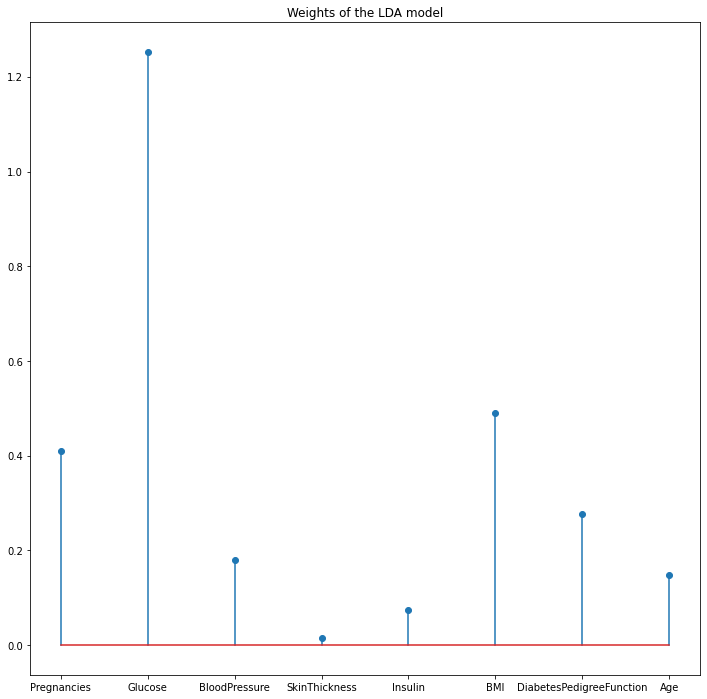

In [28]:
LDA = LinearDiscriminantAnalysis(shrinkage=gridsLDA.best_params_["shrinkage"], solver=gridsLDA.best_params_["solver"])
LDA.fit(Xtrain_norm, Ytrain)

weights_lda = LDA.coef_

fig = plt.figure(figsize=(12, 12))
plt.stem(pima_data['varnames'], np.abs(weights_lda[0]))
plt.title("Weights of the LDA model")

The 3 most powerfull weights are : Glucose, BMI, Pregnancies. As I exlplained earlier from a medical perspective, Glucose and BMI are relevant variables that can help detecting diabete. Our model detected another important variable : the number of pregnancies. From a medical perspecitve it also makes sense. Indeed, the number of pregnancies can lead to a diabete because during the pregnancy ,there is an increase in the blood sugar in the mother-to-be because of the baby. It can lead to a diabete of type II if the number of pregnancies increases.

In contrast the least powerfull variable is the skin thickness. We could try to explain this from a medical perspective : there are many medical explanation (other than diabete) to an anormal skin thickness. People having an anormal skin thickness are not always diabetic.

This weight analysis allows to understand how the LDA model takes its decisions.

#### Confusion matrix of the LDA

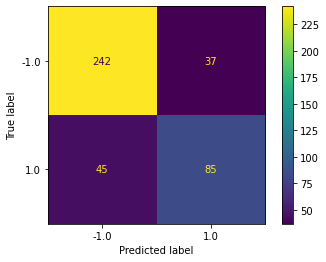

In [29]:
cm = confusion_matrix(Ytest, gridsLDA.predict(Xtest_norm))
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gridsLDA.classes_)
cm_disp.plot()

false_negative_rate = cm[1][0]/(cm[1][0] + cm[1][1])
print("Flase negative rate = "+str(false_negative_rate))

This false negative rate is pretty high for this type of applications : Healthcare is a sensitive application. It could lead to dramatic consequences for people with false results. Without any treatment, diabetic people could have severe complications. Therefore, the false negative rate should be very low, 36% is too high.

Let's work with non linear models and try to improve performances.

## Now we will work with non linear models

### Random Forest

In [30]:
RFC = RandomForestClassifier()
RFC.fit(Xtrain_norm, Ytrain)
RFC_accuracy = RFC.score(Xtest_norm, Ytest)
RFC_auc = roc_auc_score(Ytest, RFC.predict_proba(Xtest_norm)[:, 1])

print("Random Forest Classifier Accuracy = "+str(RFC_accuracy))
print("Random Forest Classifier AUC score = "+str(RFC_auc))

Random Forest Classifier Accuracy = 0.7677261613691931
Random Forest Classifier AUC score = 0.8410669975186104


Let's try to get better performances with a GridSearchCV

In [31]:
RFC = RandomForestClassifier()

params={'n_estimators': [5,25,50,75,100,200,500], 'criterion': ['gini', 'entropy'], 'max_depth' : [2,5,7,10,30,50,100,150,200]}

gridsRFC=GridSearchCV(RFC, params, cv=cv, n_jobs=-1)
gridsRFC.fit(Xtrain_norm, Ytrain)

gridsRFC.best_params_

{'criterion': 'gini', 'max_depth': 100, 'n_estimators': 200}

In [32]:
gridsRFC_accuracy = gridsRFC.score(Xtest_norm, Ytest)
gridsRFC_auc = roc_auc_score(Ytest, gridsRFC.predict_proba(Xtest_norm)[:, 1])

print("Random Forest Classifier Accuracy = "+str(gridsRFC_accuracy))
print("Random Forest Classifier AUC score = "+str(gridsRFC_auc))

Random Forest Classifier Accuracy = 0.7799511002444988
Random Forest Classifier AUC score = 0.8435897435897436


### SVC

In [33]:
svc = SVC(probability=True)
svc.fit(Xtrain_norm, Ytrain)
svc_accuracy = svc.score(Xtest_norm, Ytest)
svc_auc = roc_auc_score(Ytest, svc.predict_proba(Xtest_norm)[:, 1])

print("SVC Accuracy = "+str(svc_accuracy))
print("SVC AUC score = "+str(svc_auc))

SVC Accuracy = 0.7750611246943765
SVC AUC score = 0.8332506203473945


Let's try to improve performances with a gridSearchCV

In [34]:
svc = SVC(probability=True)

params={'C':np.linspace(0.001,10,100), "gamma":[1,10,20,50,100,1000,'auto','scale']}

gridsSvc=GridSearchCV(svc,params,cv=cv,n_jobs=-1)
gridsSvc.fit(Xtrain_norm,Ytrain)

gridsSvc.best_params_

{'C': 0.30400000000000005, 'gamma': 'auto'}

In [35]:
gridsSvc_accuracy = gridsSvc.score(Xtest_norm,Ytest)
gridsSvc_auc = roc_auc_score(Ytest, gridsSvc.predict_proba(Xtest_norm)[:, 1])

print("SVC Accuracy with optimal C = "+str(gridsSvc_accuracy))
print("SVC AUC score with optimal C = "+str(gridsSvc_auc))

SVC Accuracy with optimal C = 0.78239608801956
SVC AUC score with optimal C = 0.8400055141990626


### Gradient Boost Classifier

In [36]:
GBC = GradientBoostingClassifier()
GBC.fit(Xtrain_norm, Ytrain)
GBC_accuracy = GBC.score(Xtest_norm,Ytest)
GBC_auc = roc_auc_score(Ytest, GBC.predict_proba(Xtest_norm)[:, 1])

print("GBC Accuracy = "+str(GBC_accuracy))
print("GBC AUC score = "+str(GBC_auc))

GBC Accuracy = 0.7677261613691931
GBC AUC score = 0.8228563551144197


Let's try to improve performances with a GridSearchCV

In [37]:
GBC = GradientBoostingClassifier()

params={"learning_rate": [0.001,0.01,0.1,1,10], "n_estimators":[5,10,25,50,75,100,200], 'max_depth':[2,5,7,10,30,50,100]}

gridsGBC=GridSearchCV(GBC,params,cv=cv,n_jobs=-1)
gridsGBC.fit(Xtrain_norm,Ytrain)

gridsGBC.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}

In [38]:
gridsGBC_accuracy = gridsGBC.score(Xtest_norm, Ytest)
gridsGBC_auc = roc_auc_score(Ytest, gridsGBC.predict_proba(Xtest_norm)[:, 1])

print("GBC Accuracy with optimal alpha = "+str(gridsGBC_accuracy))
print("GBC AUC score with optimal alpha = "+str(gridsGBC_auc))

GBC Accuracy with optimal alpha = 0.7652811735941321
GBC AUC score with optimal alpha = 0.8247863247863247


### MLP

In [130]:
input_shape = Xtrain_norm.shape[1]
output_shape = 1

# Structure of NN definition
model = Sequential()
model.add(Dense(100, input_dim=input_shape, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(output_shape, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 100)               900       
                                                                 
 dropout_44 (Dropout)        (None, 100)               0         
                                                                 
 dense_78 (Dense)            (None, 20)                2020      
                                                                 
 dropout_45 (Dropout)        (None, 20)                0         
                                                                 
 dense_79 (Dense)            (None, 20)                420       
                                                                 
 dropout_46 (Dropout)        (None, 20)                0         
                                                                 
 dense_80 (Dense)            (None, 1)               

In [131]:
binary_Ytrain = Ytrain.copy()
binary_Ytrain[binary_Ytrain==-1]=0

In [132]:
model.fit(Xtrain_norm, binary_Ytrain, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
4/4 [==============================] - 1s 58ms/step - loss: 0.6877 - accuracy: 0.5250 - val_loss: 0.6864 - val_accuracy: 0.6667
Epoch 2/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6683 - accuracy: 0.7000 - val_loss: 0.6725 - val_accuracy: 0.6667
Epoch 3/50
4/4 [==============================] - 0s 12ms/step - loss: 0.6622 - accuracy: 0.6833 - val_loss: 0.6640 - val_accuracy: 0.6167
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6508 - accuracy: 0.7167 - val_loss: 0.6560 - val_accuracy: 0.6667
Epoch 5/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6320 - accuracy: 0.7500 - val_loss: 0.6472 - val_accuracy: 0.6500
Epoch 6/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6328 - accuracy: 0.7042 - val_loss: 0.6378 - val_accuracy: 0.6500
Epoch 7/50
4/4 [==============================] - 0s 10ms/step - loss: 0.6149 - accuracy: 0.7750 - val_loss: 0.6274 - val_accuracy: 0.6833
Epoch 8/50
4/4 [===========

In [133]:
binary_Ytest = Ytest.copy()
binary_Ytest[binary_Ytest==-1]=0

In [134]:
model.evaluate(Xtest_norm, binary_Ytest)

13/13 [==============================] - 0s 2ms/step - loss: 0.5022 - accuracy: 0.7677


[0.5022442936897278, 0.7677261829376221]

With the MLP model we do not get very good performances. This is probably because our training dataset does not have enough data (only 300 samples).

### Discussion on all models




In [136]:
RFC = {"ACC":gridsRFC_accuracy, "AUC":gridsRFC_auc}
SVC = {"ACC":gridsSvc_accuracy, "AUC":gridsSvc_auc}
MLP = {"ACC":model.evaluate(Xtest_norm, binary_Ytest, verbose=0)[1], "AUC":np.nan}

RFC = pd.Series(RFC)
SVC = pd.Series(SVC)
MLP = pd.Series(MLP)

tab["RFC"] = RFC
tab["SVC"] = SVC
tab["MLP"] = MLP
display(tab.T)

,ACC,AUC
LDA,0.799511,0.854480
QDA,0.782396,0.840336
LR,0.770171,0.841274
RFC,0.779951,0.843590
SVC,0.782396,0.840006
MLP,0.767726,NaN


When we look at previous performances, we can notice that the model with the best performances is the LDA model. However, as we saw previously whith the confusion matrix, this model has too many false negative predictions. Therefore, it could be problematic to use this model. 

In order to improve performances, a solution could be to increase the number of sample in our training dataset (we will not do it because we do not have enough data). We could imagine that with a bigger training dataset, non linear models such the MLP would perform better.

Then, if we look at our problem from a practical and medical perspective we would prefer to work with a linear model. Indeed, linear models are easier to interpret. They have one weight for every parameter that you can easily interpret (as we did earlier). Non-linear models are more complex and difficult to interpret. Therefore, for this application it could be more practical to use a linear model in order to have a better understanding of our model. The model interpretation could be share with health professionals in order to improve the model.

So, if we could get better performances with LDA or LR, it could be more practical.